# Problem 3: Data pipeline in science
In this notebook, I reproduce the neuro_pipeline.ipynb notebook to answer Problem 3 Tasks 1 and 2. 

In [1]:
import numpy as np
import pylab as pl
%matplotlib inline

## 1) Loading and plotting the data

In [2]:
Vtrace = np.loadtxt('./data/john_experiment_0.dat')
tbins = np.arange(0, 60, 0.00005) # 1 min recording with 50mu s sampling

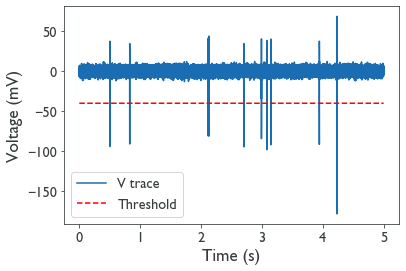

In [3]:
pl.plot(tbins[0:100000], Vtrace[0:100000], label = 'V trace')
threshold = -40
pl.plot(tbins[0:100000], np.ones(100000)*threshold, '--r', label = 'Threshold')
pl.xlabel('Time (s)')
pl.ylabel('Voltage (mV)')
pl.legend()

## 2) Extracting spikes: the central object in the dataset

Text(0, 0.5, 'Voltage (mV)')

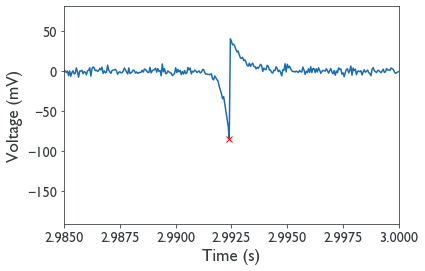

In [4]:
above = (Vtrace < threshold)
spikes = above[1:] < above[0:-1]

spikeTimes = tbins[np.where(spikes)]
spikeVoltages = Vtrace[np.where(spikes)]

pl.plot(tbins, Vtrace, spikeTimes, spikeVoltages, 'xr')
pl.xlim([2.985, 3.0])
pl.xlabel('Time (s)')
pl.ylabel('Voltage (mV)')

The plot shows a typical spike: a short biphasic voltage pulse about 2ms long.

Now that the spiketimes [i.e. the times when a spike occured] have been saved, we can study some of their statistical properties.

## 3) Spike time analysis

First, let's look at the inter-spike intervals, i.e. the distribution of waiting times between two of these events.

Text(0, 0.5, 'Frequency')

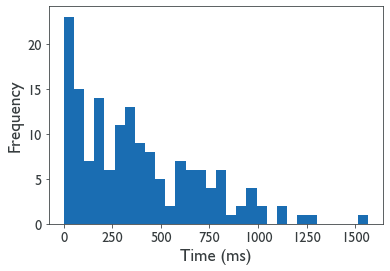

In [5]:
ISI = np.diff(spikeTimes)
ISIhist = pl.hist(ISI*1000, 30)
pl.xlabel('Time (ms)')
pl.ylabel('Frequency')

In [6]:
import scipy.optimize as opt
import scipy as sc

def normpdf(x, mu, sd, denom):
    num = np.exp(-(x-mu)**2/(2*sd*sd))
    return num/denom

probabilities = ISIhist[0]/np.sum(ISIhist[0])
distance_between_spikes = ISIhist[1][:-1]

popt, pcov = opt.curve_fit(normpdf, np.log(distance_between_spikes), probabilities)
print(popt)

[0.79507444 2.83046037 5.08225159]


In [7]:
data_fitted = normpdf(np.log(distance_between_spikes), *popt)

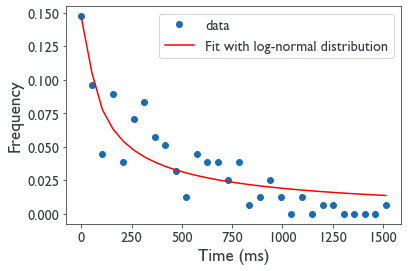

In [8]:
pl.plot(distance_between_spikes,probabilities,'o', label = 'data')
pl.plot(distance_between_spikes, data_fitted,'r-', label = 'Fit with log-normal distribution')
pl.xlabel('Time (ms)')
pl.ylabel('Frequency')
pl.legend()

Now that the data and spike intervals are loaded, we can answer Tasks 1 and 2

**Task 1: (a) Write a new function to fit the inter-spike-intervals with a Poissonian distribution, calculate and print the mean.**

The Poisson distribution is defined by:
$$ p(x,\mu) = \frac{e^{-\mu} \mu^x}{x!} $$
The Poisson distribution is meant to describe count data (i.e. integers), so fitting to the continuous data like what is done for the log-normal is not going to work. We need to re-scale and re-bin the data into integer bins by making a new histogram:

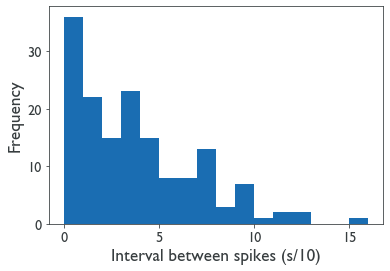

In [9]:
bins = range(0,17,1) # Need to be integers
Ns,bins,_ = pl.hist(ISI*10,bins=bins,)
probs = Ns/np.sum(Ns)
pl.xlabel('Interval between spikes (s/10)')
pl.ylabel('Frequency')
bin_cens = np.array([int((bins[i]+bins[i+1])/2.) for i in range(len(bins)-1)]) 
# int() enforces integers, the above line makes sure we have the same size array as probs

In [10]:
from scipy.special import factorial
def poisson_model(x, lamb):
    return np.exp(-lamb)*(lamb**x/factorial(x))  

In [11]:
popt, pcov = opt.curve_fit(poisson_model, bin_cens, probs )
mu=popt[0]

In [12]:
print("Best-fit Poisson mu={0:1.2f} seconds".format(mu/10.))

Best-fit Poisson mu=0.24 seconds


Text(0, 0.5, 'Frequency')

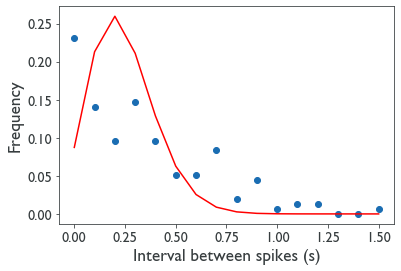

In [13]:
pl.plot(bin_cens/10.,probs,'o',label='data')
pl.plot(bin_cens/10.,poisson_model(bin_cens,mu),'r-',label='Poisson fit')
pl.xlabel('Interval between spikes (s)')
pl.ylabel('Frequency')

**(b) replace the fixed threshold of -40 with a method to adapt to different noise level, i.e. fix the threshold to negative 5 times the standard deviations of the voltage values.**

-18.67700255331641


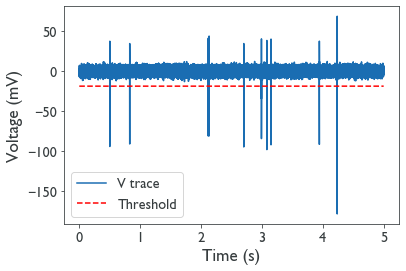

In [14]:
threshold = -5*np.std(Vtrace)
print(threshold)
pl.plot(tbins[0:100000], Vtrace[0:100000], label = 'V trace')
pl.plot(tbins[0:100000], np.ones(100000)*threshold, '--r', label = 'Threshold')
pl.xlabel('Time (s)')
pl.ylabel('Voltage (mV)')
pl.legend()

Text(0, 0.5, 'Voltage (mV)')

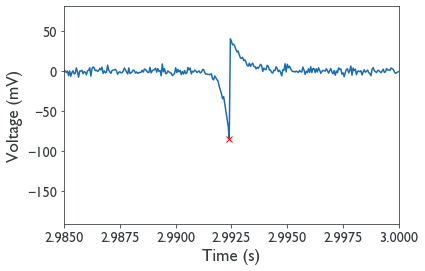

In [15]:
above = (Vtrace < threshold)
spikes = above[1:] < above[0:-1]

spikeTimes = tbins[np.where(spikes)]
spikeVoltages = Vtrace[np.where(spikes)]

pl.plot(tbins, Vtrace, spikeTimes, spikeVoltages, 'xr')
pl.xlim([2.985, 3.0])
pl.xlabel('Time (s)')
pl.ylabel('Voltage (mV)')

Text(0, 0.5, 'Frequency')

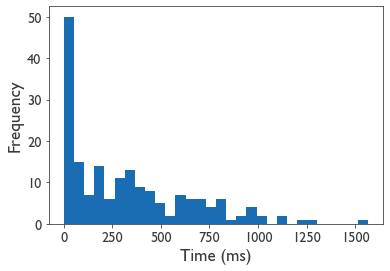

In [16]:
ISI = np.diff(spikeTimes)
ISIhist = pl.hist(ISI*1000, 30)
pl.xlabel('Time (ms)')
pl.ylabel('Frequency')

In [17]:
probabilities = ISIhist[0]/np.sum(ISIhist[0])
distance_between_spikes = ISIhist[1][:-1]

popt, pcov = opt.curve_fit(normpdf, np.log(distance_between_spikes), probabilities)
print(popt)

[-1.17237546  3.37874258  3.46598549]


In [18]:
data_fitted = normpdf(np.log(distance_between_spikes), *popt)

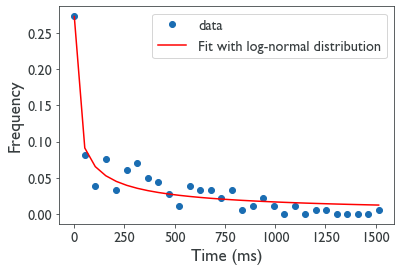

In [19]:
pl.plot(distance_between_spikes,probabilities,'o', label = 'data')
pl.plot(distance_between_spikes, data_fitted,'r-', label = 'Fit with log-normal distribution')
pl.xlabel('Time (ms)')
pl.ylabel('Frequency')
pl.legend()

Text(0, 0.5, 'Frequency')

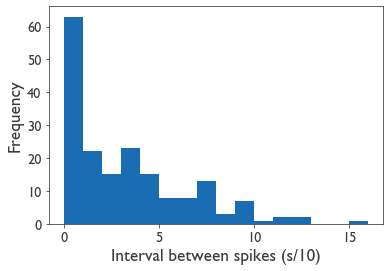

In [20]:
# Re-fit with Poisson
Ns,bins,_ = pl.hist(ISI*10,bins=bins) # using same bins as before
probs = Ns/np.sum(Ns)
pl.xlabel('Interval between spikes (s/10)')
pl.ylabel('Frequency')

In [21]:
popt, pcov = opt.curve_fit(poisson_model, bin_cens, probs )
mu=popt[0]

In [22]:
print("Best-fit Poisson mu={0:1.2f} seconds".format(mu/10.))

Best-fit Poisson mu=0.10 seconds


Text(0, 0.5, 'Frequency')

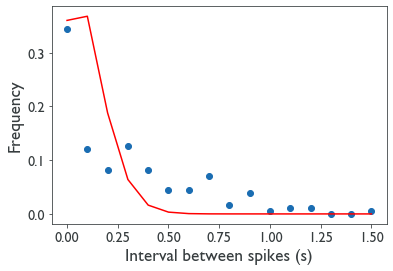

In [23]:
pl.plot(bin_cens/10.,probs,'o',label='data')
pl.plot(bin_cens/10.,poisson_model(bin_cens,mu),'r-',label='Poisson fit')
pl.xlabel('Interval between spikes (s)')
pl.ylabel('Frequency')

The means and standard deviations of both the Poisson and log-normal distributions decrease because there are more short interval spikes than long interval spikes in the case where we made the threshold more aggressive.

**Task 2: (in words) how would you describe the essential blocks of this pipeline? What is the relational structure? Are there obvious things about the code that should be improved?**

The essential blocks are:

- 1) Loading the data
- 2) Thresholding and spike extraction
- 3) Model-fitting

Loading the data presents a bottleneck because it takes approximately 5 seconds to read it from file. For example, if one wants to re-run the pipeline from the beginning to test all steps in this notebook, they need to reload from file each time. If the data are stored in a database, extracting the data will be much faster, especially when we move to analyses on other datasets, like the others included in the downloaded folder.

Thresholding is done efficiently because of the python masking that is performed. However, the threshold was hard-coded to -40, so it should be determined from the data itself, as suggested in Task 1, part b. A test of robustness could be performed, i.e. calculate the parameters of the log-normal/Poisson for a range of thresholds (e.g. -1 std, -2 std, ..., -10 std) and look for convergence in the parameters. 

The Poisson model fit that I implemented required re-scaling and re-binning of the data. This means that I get a different spike interval distribution depending on which fitting function I want to use. This is suboptimal, as it makes the pipeline more complicated and it might make  model comparison later harder to interpret. A better way to do the Poisson fit would be with a Poisson regression, i.e. a log-linear model, which does not require re-scaling or re-binning the data. The issue with this approach is how to handle the 0 probability values in the histogram. A zero-inflated Poisson regression model may be a solution to this problem. This would allow me to use the same binning scheme as the one used in the example for the log-normal fit.

Finally, some tests or at the very least assert statements should be included to, for example, make sure the data are read in with the assumed data types and lengths. If one is looking up data from a remote server and the connection goes down they might read in an empty array, which could break the downstream part of the pipeline such as the model-fitting, but it could take time for them to debug this behavior.